# Taipei Cycle Loyal Buyers

In [1]:
import pandas as pd

df = pd.read_csv('C:/Users/2093/Desktop/Data Center/08. 小專案/cycle各國競爭力/buyer.csv',
                 engine='python')
df.columns = ['name', 'country'] + list(df.columns[2:])
print('Number of unique buyers before merge: {:,}'.format(len(df)))

com_map = pd.read_csv('C:/Users/2093/Desktop/Data Center/08. 小專案/cycle各國競爭力/buyer_map.csv',
                      engine='python', header=0, names=['raw', 'name']).drop_duplicates()

df = df.merge(com_map, on='name', how='left')
df = df[['raw', 'name', 'country'] + list(df.columns[df.columns.str.startswith('20')])]

Number of unique buyers before merge: 21,450


### 1. Country Name

In [2]:
import numpy as np
import distance

df['country'] = df['country'].str.strip().str.lower().str.replace(r'[，*() ]', r'')
raw = np.sort(df['country'].unique())
len_raw = len(raw)
m = np.zeros((len_raw, len_raw))

for i in range(len_raw):
    for j in range(len_raw):
        m[i, j] = distance.levenshtein(raw[i], raw[j])
        
raw_df = pd.DataFrame(m, index=raw)
raw_df.columns = raw
raw_df.replace(0, np.nan, inplace=True)

# for ind, val in raw_df.idxmin().iteritems():
#     print(ind, val)

alias_map = {'france,metropolitan': 'france',
             'mainlandchina': 'china',
             'sweoish': 'sweden'}
df['country'] = df['country'].replace(alias_map)

### 2. Company Name

#### 2.1 Common Patterns

In [3]:
pd.Series(' '.join(df['raw'][df['raw'].notnull()]).split(' ')).value_counts()[:50]

LTD.             1780
CO.,             1713
LTD              1415
BIKE              698
BICYCLE           568
CO.,LTD.          560
CO.,LTD           498
SPORTS            497
CYCLE             489
                  470
INC.              461
INTERNATIONAL     403
LIMITED           382
TRADING           366
CO.               353
BIKES             346
&                 320
GMBH              302
GROUP             290
TECHNOLOGY        277
CORPORATION       272
CYCLES            267
COMPANY           191
BICYCLES          186
SPORT             179
PTE               169
INC               161
SHENZHEN          156
TIANJIN           152
CO                145
BHD               140
INDUSTRY          133
CORP.             127
INDUSTRIAL        127
SDN               126
THE               126
CYCLING           124
ENTERPRISE        118
PRODUCTS          115
SRL               111
ASIA              107
LLC               106
S.A.              104
TRADE             103
DESIGN            103
INDUSTRIES

In [4]:
suffixes = ['ag',
            'co',
            'coinc',
            'coltd',
            'copte',
            'corp',
            'corpltd',
            'corporation',
            'corporationltd',
            'enterprise',
            'gmbh',
            'gmbh&cokg',
            'inc',
            'intlco',
            'limited',
            'ltd',
            'ltdco',
            'private',
            'pte',
            'pteltd',
            'sdnbhd',
            'spolsro',
            'srl',
            'sro',
            'tradingco',
            '有限公司',
            '有限責任公司',
            '股份有限公司']

suffixes.sort(key=len, reverse=True)
df['name'] = df['name'].str.strip().str.lower().str.replace(r' ', r'').str.replace(r'\(.*?\)', r'')
df['name'] = df['name'].str.replace(r's[\D]{1}[\D]{1}bhd$', r'sdnbhd')

for s in suffixes:
    df['name'] = df['name'].str.replace(s + r'$', r'')

#### 2.2 Duplicates as a Result of Suffixes or Join Operation

In [5]:
df.groupby(['name', 'country'])['raw'].count().sort_values(ascending=False)[:30]

name                        country                       
performance                 unitedstates                      19
giant                       china                             17
shimano                     japan                             14
specialized                 unitedstates                      14
                            china                             13
j&bimporters                unitedstates                      12
shimano                     singapore                         12
                            china                             12
bikesmart                   unitedstates                      12
hangzhoujunshengindustrial  china                             12
universeagency              czechrepublic                     11
daytonindustrial            hongkong                          11
trekbicycle                 unitedstates                      11
canrocus                    unitedstates                      11
odbike                      kor

In [6]:
df[df.name == 'performance']

,raw,name,country,2012,2013,2014,2015,2016,2017
15453,PERFORMANCE,performance,unitedstates,0,0,0,1,0,0
15465,PERFORMANCEINC,performance,unitedstates,0,0,0,0,0,5
15466,"PERFORMANCE,INC",performance,unitedstates,0,0,0,0,0,5
15467,"PERFORMANCE,INC.",performance,unitedstates,0,0,0,0,0,5
15468,PERFORMANCEINC.,performance,unitedstates,0,0,0,0,0,5
15469,"Performance, Inc.",performance,unitedstates,0,0,0,0,0,5
15470,PERFORMANCE INC.,performance,unitedstates,0,0,0,0,0,5
15471,PERFORMANCE INC,performance,unitedstates,0,0,0,0,0,5
15472,"PERFORMANCE, INC",performance,unitedstates,0,0,0,0,0,5
15473,"Performance, Inc",performance,unitedstates,0,0,0,0,0,5


In [7]:
df['raw'].fillna('', inplace=True)
df['name'].fillna('', inplace=True)

def merge_duplicates(gp):
    raw_names = '|'.join(gp['raw'].sort_values())
    merged = gp.drop('raw', axis=1).drop_duplicates()
    merged['raw'] = raw_names
    merged = merged.groupby('raw').sum()
    return merged

df = df.groupby(['name', 'country']).apply(merge_duplicates)
print('Number of unique buyers after merging duplicates: {:,}'.format(len(df)))

Number of unique buyers after merging duplicates: 19,820


#### 2.3 Variants

In [8]:
from difflib import SequenceMatcher

def similarity(a, b):
    s = SequenceMatcher(None, a, b)
    similarity = s.ratio()
    return similarity

df.reset_index(inplace=True)
df = df.sort_values(['country', 'name']).reset_index(drop=True)
df['forward'] = df.groupby('country')['name'].shift().fillna('')
df['f_sim'] = list(map(similarity, df['name'], df['forward']))
df.loc[df['f_sim'] > .75, ['name', 'forward', 'f_sim']].sort_values('f_sim').head(20)

,name,forward,f_sim
19157,rechargeablepowerenergynorthamericallc,rechargeablepowerenergh,0.754098
19763,productionandtradingltdcoviethung,productionandtrading,0.754717
16061,elcheparqueindustrialc,elcheparqueempresarialc,0.755556
16558,aastradingltdpart,aastradinglimitedpartnership,0.755556
574,sheppardcyclesaustralia,sheppardcycles,0.756757
1612,biciletasbeldalimitada,bicicletasbelda,0.756757
2999,kunshanlandontrade,kunshanlandonsports,0.756757
4321,winspacesportsequipment,winspacesports,0.756757
128,advancetradersaustralia,advancetraders,0.756757
4406,xiamenyeuchuancompositetechnology,xiamenyehoocompositesscienceandtechnology,0.756757


In [9]:
from functools import reduce

def merge_variants(gp, start_idx, end_idx):
    subset = gp.loc[range(start_idx, end_idx+1), 'name':'2017'].drop('country', axis=1)
    merged = pd.DataFrame(subset.loc[:, '2012':'2017'].sum()).T
    merged['name'] = subset['name'].iloc[0]
    merged['raw'] = '|'.join(set('|'.join(subset['raw']).split('|')))
    merged.set_index(['name', 'raw'], inplace=True)
    return merged

def merge_variants_c(gp):
    variant_idx = gp[gp['f_sim'] >= .75].index
    start_idx = [x for x in variant_idx if x - 1 not in variant_idx]
    start_idx = sorted(np.array(start_idx) - 1)
    end_idx = sorted([x for x in variant_idx if x + 1 not in variant_idx])
    
    singleton_idx = set(gp.index) - set(start_idx + list(variant_idx))
    singleton = gp.loc[singleton_idx, 'name':'2017'].drop('country', axis=1).set_index(['name', 'raw'])
    gp_rs = singleton
    
    if len(start_idx):
        merged_map = map(lambda x, y: merge_variants(gp, x, y), start_idx, end_idx)
        merged = reduce(lambda x, y: pd.concat([x, y], axis=0), merged_map)
        gp_rs = gp_rs.append(merged)
       
    return gp_rs

df = df[df['name'] != '']
df = df.groupby('country').apply(merge_variants_c)
print('Number of unique buyers after merging variants: {:,}'.format(len(df)))

Number of unique buyers after merging variants: 17,939


In [10]:
start_yr = 2013
end_yr = 2017
loyal = df[df.loc[:, str(start_yr):str(end_yr)].all(axis=1)]
loyal.reset_index().to_csv('loyal_buyer.csv', index=False)
print('Number of loyal buyers throughout {}-{}: {}'.format(start_yr, end_yr, len(loyal)))

Number of loyal buyers throughout 2013-2017: 481


#### 2.4 Bonus

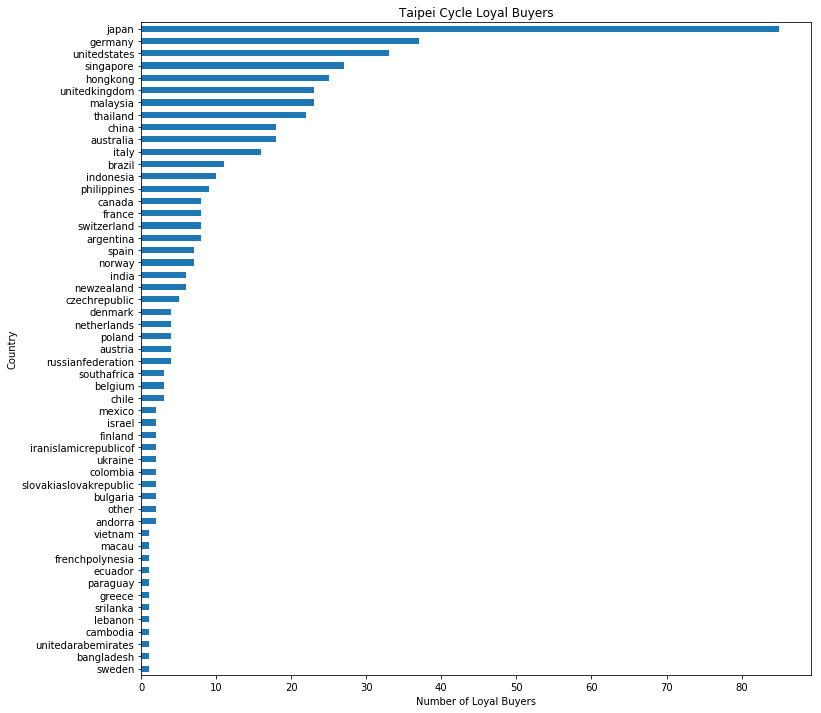

In [11]:
import matplotlib.pyplot as plt

ax = loyal.index.get_level_values('country').value_counts(ascending=True).plot(
    kind='barh', figsize=(12, 12))
ax.set_title('Taipei Cycle Loyal Buyers')
ax.set_xlabel('Number of Loyal Buyers')
ax.set_ylabel('Country')
plt.show()